#### *Applied Mathematical Finance 2*

## <ins> *Seminar 5: Risk neutral distribution* </ins>

### 1. Calibration to plain vanilla options

Given an implied volatility smile $\sigma(T, K)$ for fixed $T$, the forward $F(0, T)$ on asset $S$, then the risk-neutral distribution of $S_T$ implied from the market can be obtained from Breeden-Litzenberger formula

$$\mathbb{Q}(S_T > K) = - \dfrac{d\tilde C(T, K)}{dK},$$

where $\tilde C(T, K) = \mathbb{E}^{\mathbb{Q}} (S_T - K)_{+}$ is the undiscounted call option price.

That is, applying the Black's formula, we immediately get that

$$\mathbb{Q}(S_T < K) =  \Phi(- d_{-}) + F \cdot \phi(d_{+}) \cdot \sqrt{T - t} \cdot \text{Skew}(K).$$

Haven't we seen it before? Yes! We had alsmot the same formula when pricing the digital call option. Namely, the digital call pays 
$$1_{ \{ S_T > K \}},$$

so its price
$$PV^{digital}_{0} = DF(0, T) \mathbb{E}^{\mathbb{Q}} \left( 1_{ \{ S_T > K \}} \right) = DF(0, T) \mathbb{Q}(S_T > K) = DF(0, T)(1 - \mathbb{Q}(S_T < K)).$$

Great, we're familiar with this. For convenice, we will denote the risk-neutral distribution (as a function of $K$) by 

$$q_{T}(K) := \mathbb{Q}(S_T < K).$$


### 2. Single assset European option pricing 

Given the arbitrary payoff function $\pi(S_T)$, the price of the corrresponding deriative is 
$$
\begin{align*}
PV_{0} = DF(0, T) \cdot \mathbb{E}^{\mathbb{Q}} [\pi(S_T)] &= DF(0, T) \cdot \int_{0}^{\infty} \pi(K) d \mathbb{Q}(S_T < K) \\ 
&= DF(0, T) \cdot \int_{0}^{\infty} \pi(K) q'_{T}(K) dK \\
&\stackrel{q_{T}(K)=u}{=} DF(0, T) \cdot \int_{0}^{1} \pi(q^{-1}_{T}(u))  du.
\end{align*}
$$

Hence, for derivative valutaion we need to know the quantile function (quantile mapping)
$$u \to q^{-1}_{T}(u).$$



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Any, Union
from scipy.stats import norm
from scipy.integrate import quad
import pandas as pd
import warnings
from scipy.interpolate import PchipInterpolator, interp1d
from collections import defaultdict
from py_vollib.black.implied_volatility import implied_volatility_of_undiscounted_option_price
warnings.filterwarnings('ignore')

In [2]:
def extract_data_for_equity_index(vols_data_path: str, forwards_path: str):
   """
   Extracts the data from given .csv files for corresponding equity asset.

   Args:
       vols_data_path: absolute (or relative) path to the volatility .csv file.  
       forwards_path: absolute (or relative) path to forwards .csv file. 
   """
   vol = pd.read_csv(vols_data_path, sep=";")
   strikes = vol.iloc[0, 3:].values.astype(float)
   volatilities = vol.iloc[1:, 3:].values.astype(float)

   dates = vol.iloc[1:, 2].values # dates are the same for both underlyings
   periods = vol.iloc[1:, 1].values # peiords are the same for both underlyings

   forws = pd.read_csv(forwards_path, sep=";")
   forwards = dict(zip(forws["Date"], forws["Forwards"]))
   return forwards, strikes, volatilities, dates, periods

In [3]:
def extract_data_for_df_curve(dfs_data_path: str):
    """
    Extracts the data from given .csv file for corresponding discount factors curve.

    Args:
        dfs_data_path: absolute (or relative) path to discount factors .csv file. 
    """
    dfs = pd.read_csv(dfs_data_path, sep=";")
    discount_factors = dict(zip(dfs["Date"], dfs["DF"]))
    return discount_factors

In [4]:
# Data extraction for .SPX

spx_forwards, spx_strikes, spx_volatilities, spx_dates, spx_periods = extract_data_for_equity_index(vols_data_path="data/ImpliedVol_SPX_full.csv",
                                                                                                    forwards_path="data/Forwards_SPX.csv")

In [5]:
# Data extraction for NKELYQ

nkelyq_forwards, nkelyq_strikes, nkelyq_volatilities, nkelyq_dates, nkelyq_periods = extract_data_for_equity_index(vols_data_path="data/ImpliedVol_NKELYQ_full.csv",
                                                                                                                   forwards_path="data/Forwards_NKELYQ.csv")

In [6]:
spx_periods, nkelyq_periods

(array(['1M', '2M', '3M', '6M', '9M', '1Y', '18M', '2Y', '3Y', '4Y', '5Y'],
       dtype=object),
 array(['1M', '2M', '3M', '6M', '9M', '1Y', '18M', '2Y', '3Y', '4Y', '5Y'],
       dtype=object))

Here and further we work with the same periods for both assets. 

In [7]:
spx_periods_floats = np.array([1, 2, 3, 6, 9, 12, 18, 24, 36, 48, 60]) / 12
nkelyq_periods_floats = np.array([1, 2, 3, 6, 9, 12, 18, 24, 36, 48, 60]) / 12

In [8]:
# Data extraction for DF

dfs = extract_data_for_df_curve(dfs_data_path="data/DFs.csv")

In [9]:
# Value date info

value_date = "05/08/2021" # value date, i.e. date at which all market data above is observed
S_spx = 4406.97 # .SPX close spot quote on 05/08/2021
S_nkel = 34.8 # .NKEL close spot quote on 05/08/2021
corr = 0.5463

In [10]:
def black_price_formula(F: float,
                        K: Union[float, np.ndarray],
                        T: float,
                        sigma: Union[float, np.ndarray],
                        isCall: bool = True,
                        df: float = 1) -> Union[float, np.ndarray]:
    """Pricing formula from Black76. Broadcasts in both forward and strike.

    Args:
        F: forward.
        K: grid of strikes.
        T: tenor.
        sigma: implied volatility.
        isCall: type of option (True if Call, False if Put).
        df: discount factor. 

    Returns 2D array in spot (rows) and strikes (columns) grid.
    """
    if isinstance(K, (float, int)):
        assert isinstance(sigma, (float, int)), "K and sigma should both either floats or np.ndarrays"
    elif isinstance(K, np.ndarray):
        assert isinstance(sigma, np.ndarray), "K and sigma should both either floats or np.ndarrays"
    else:
        raise TypeError("K and sigma should both either floats or np.ndarrays")
    
    stddev = sigma * np.sqrt(T)
    d1 = np.log(F / K) / stddev + 0.5 * stddev
    d2 = d1 - stddev
    theta = 1.0 if isCall else -1.0
    return df * theta * (F * norm.cdf(theta * d1) - K * norm.cdf(theta * d2))

In [11]:
def volatility_interpolator(strikes: np.ndarray, volatilities: np.ndarray):
    """
    Returns the volatility interpolator.
    """
    # monotone cubic splines interpolator
    return PchipInterpolator(x=np.log(strikes), y=volatilities, extrapolate=True)

In [12]:
def create_implied_vol_curves(periods: np.array, strikes: np.ndarray, volatilities: np.ndarray):
    """
    Crates interpolated implied vol curves and corresponding strikes for each tenor. 

    Args:
        periods: array of periods from implied vol termstrucutre backbone. 
        strikes: array of all strikes. 
        volatilities: 2d array of volatilities. 
    """
    period_to_strikes_and_volatility_curve_mapping = dict()
    for i, period in enumerate(periods):
        volatilities_per_period = volatilities[i]
        nont_null_vol_mask = ~np.isnan(volatilities_per_period)
        selected_strikes = strikes[nont_null_vol_mask]
        selected_vols = volatilities_per_period[nont_null_vol_mask]

        vol_interpolator = volatility_interpolator(strikes=selected_strikes, 
                                                   volatilities=selected_vols) # monotone cubic splines interpolator

        period_to_strikes_and_volatility_curve_mapping[period] = {"strikes": selected_strikes,
                                                                  "vols": vol_interpolator}
    return period_to_strikes_and_volatility_curve_mapping

In [13]:
periods_to_plot = ["3M", "6M", "1Y", "18M", "2Y"]

period_to_strikes_and_volatility_curve_mapping_SPX = create_implied_vol_curves(periods=spx_periods, 
                                                                               strikes=spx_strikes,
                                                                               volatilities=spx_volatilities)

period_to_strikes_and_volatility_curve_mapping_NKEL = create_implied_vol_curves(periods=nkelyq_periods, 
                                                                                strikes=nkelyq_strikes,
                                                                                volatilities=nkelyq_volatilities)

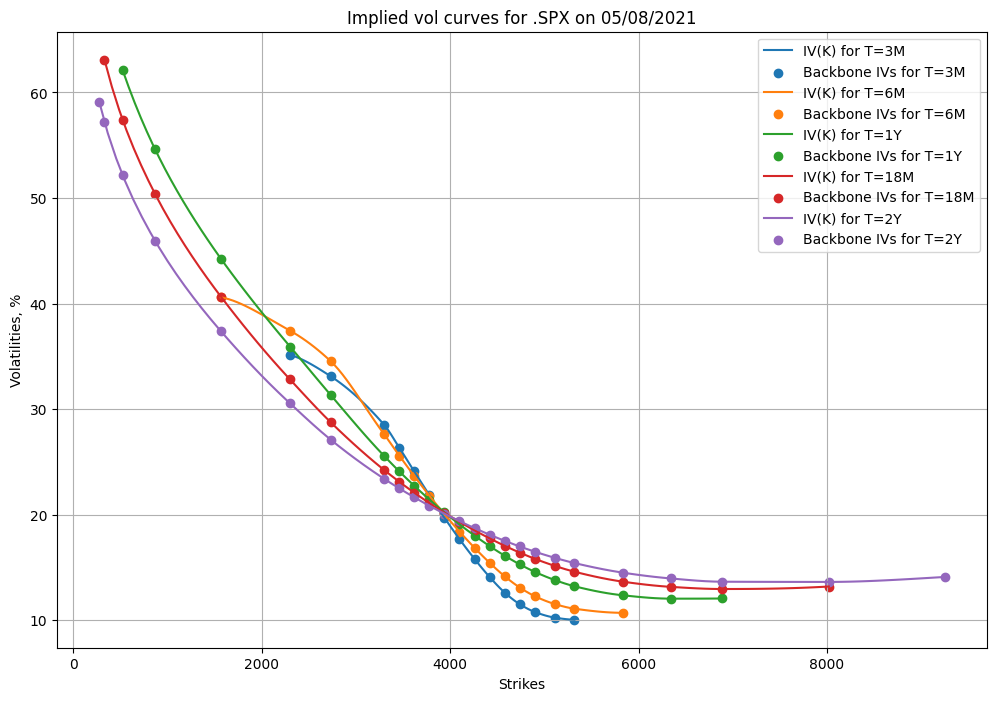

In [14]:
plt.figure(figsize=(12, 8))

for period_to_plot in periods_to_plot:
    strikes_and_volatility_curve_mapping = period_to_strikes_and_volatility_curve_mapping_SPX[period_to_plot]
    selected_strikes = strikes_and_volatility_curve_mapping["strikes"]
    vol_interpolator = strikes_and_volatility_curve_mapping["vols"]
    selected_vols = vol_interpolator(np.log(selected_strikes))

    strike_min, strike_max = np.min(selected_strikes), np.max(selected_strikes)
    high_frequency_strikes_grid = np.linspace(strike_min, strike_max, 100)

    plt.plot(high_frequency_strikes_grid, vol_interpolator(np.log(high_frequency_strikes_grid)) * 100, label="IV(K) for T={}".format(period_to_plot))
    plt.scatter(selected_strikes, selected_vols * 100, label="Backbone IVs for T={}".format(period_to_plot))

plt.title("Implied vol curves for .SPX on {}".format(value_date))
plt.xlabel("Strikes")
plt.ylabel("Volatilities, %")
plt.grid()
plt.legend()
plt.show()

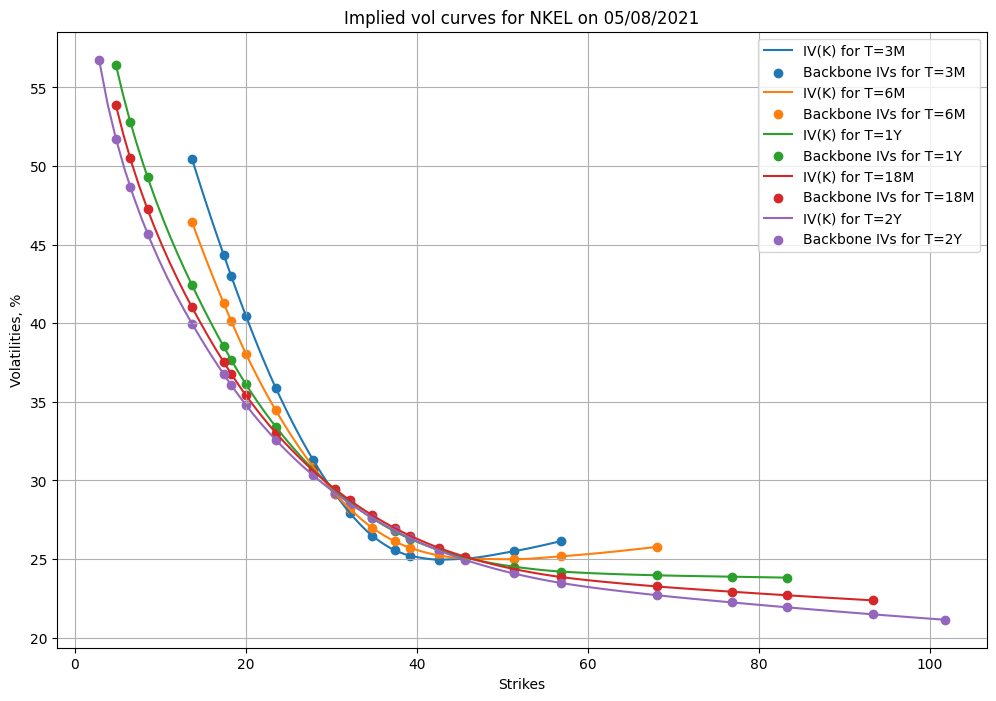

In [15]:
plt.figure(figsize=(12, 8))

for period_to_plot in periods_to_plot:
    strikes_and_volatility_curve_mapping = period_to_strikes_and_volatility_curve_mapping_NKEL[period_to_plot]
    selected_strikes = strikes_and_volatility_curve_mapping["strikes"]
    vol_interpolator = strikes_and_volatility_curve_mapping["vols"]
    selected_vols = vol_interpolator(np.log(selected_strikes))

    strike_min, strike_max = np.min(selected_strikes), np.max(selected_strikes)
    high_frequency_strikes_grid = np.linspace(strike_min, strike_max, 100)

    plt.plot(high_frequency_strikes_grid, vol_interpolator(np.log(high_frequency_strikes_grid)) * 100, label="IV(K) for T={}".format(period_to_plot))
    plt.scatter(selected_strikes, selected_vols * 100, label="Backbone IVs for T={}".format(period_to_plot))

plt.title("Implied vol curves for NKEL on {}".format(value_date))
plt.xlabel("Strikes")
plt.ylabel("Volatilities, %")
plt.grid()
plt.legend()
plt.show()

In [16]:
def get_forwards_at_periods(forwards, dates, periods):
    """
    Returns the forward prices at given periods. 

    Args:
        forwards: array of forwards at dates. 
        dates: array of dates at which forwards are given.
        periods: periods for which forwards should be computed. 
    """
    forwards_at_periods = np.zeros_like(periods)
    for i, period in enumerate(periods):
        index_of_period = np.where(periods == period)[0][0]
        date = dates[index_of_period]
        forwards_at_periods[i] = forwards[date]
    return forwards_at_periods   

In [17]:
forwards_at_periods_SPX = get_forwards_at_periods(forwards=spx_forwards, dates=nkelyq_dates, periods=spx_periods)
forwards_at_periods_SPX

array([4401.614136, 4397.703626, 4395.752398, 4384.897632, 4374.015523,
       4362.02602, 4342.977289, 4326.438677, 4311.232, 4307.861344,
       4312.166238], dtype=object)

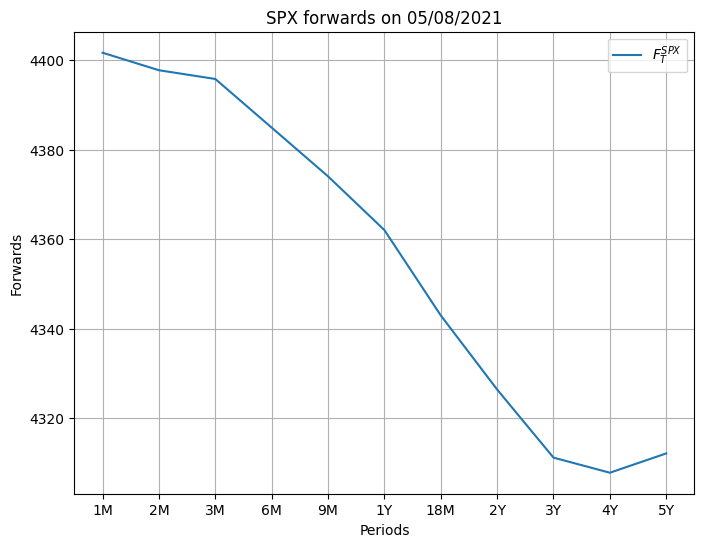

In [18]:
plt.figure(figsize=(8, 6))
plt.title("SPX forwards on {}".format(value_date))
plt.plot(spx_periods, forwards_at_periods_SPX, label="$F^{SPX}_T$")
plt.xlabel("Periods")
plt.ylabel("Forwards")
plt.grid()
plt.legend()
plt.show()

In [19]:
forwards_at_periods_NKEL = get_forwards_at_periods(forwards=nkelyq_forwards, dates=nkelyq_dates, periods=nkelyq_periods)
forwards_at_periods_NKEL

array([34.85365329, 34.36373567, 34.36733799, 33.89311711, 33.90577283,
       33.38596108, 32.50531868, 32.07398707, 30.97983559, 30.02119494,
       29.15679669], dtype=object)

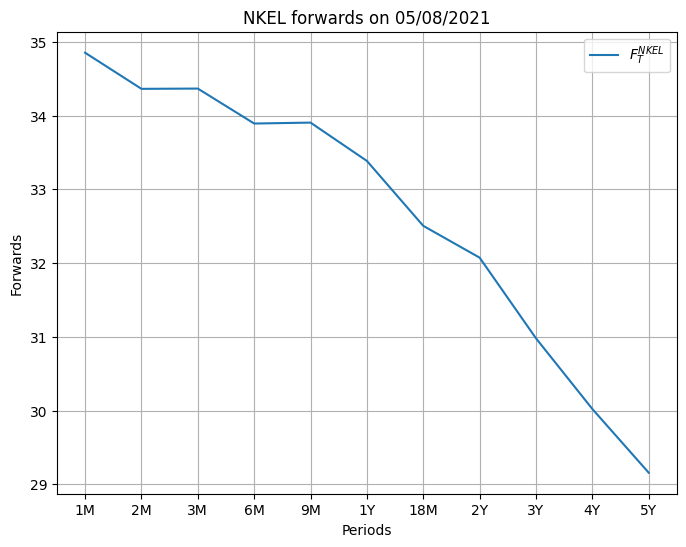

In [20]:
plt.figure(figsize=(8, 6))
plt.title("NKEL forwards on {}".format(value_date))
plt.plot(nkelyq_periods, forwards_at_periods_NKEL, label="$F^{NKEL}_T$")
plt.xlabel("Periods")
plt.ylabel("Forwards")
plt.grid()
plt.legend()
plt.show()

In [21]:
dfs_at_periods = get_forwards_at_periods(forwards=dfs, dates=nkelyq_dates, periods=nkelyq_periods)
dfs_at_periods

array([0.999892057, 0.999787607, 0.999679687, 0.999286131, 0.998881378,
       0.99841643, 0.996875689, 0.994346309, 0.985252193, 0.973503086,
       0.960228542], dtype=object)

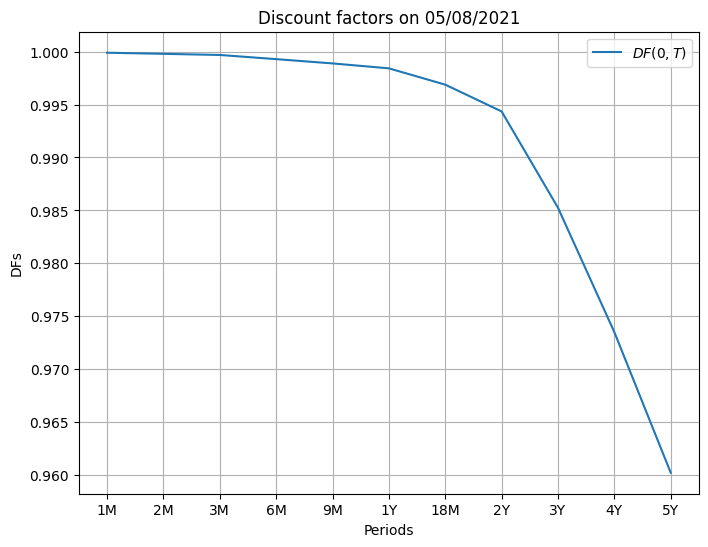

In [22]:
plt.figure(figsize=(8, 6))
plt.title("Discount factors on {}".format(value_date))
plt.plot(nkelyq_periods, dfs_at_periods, label="$DF(0, T)$")
plt.xlabel("Periods")
plt.ylabel("DFs")
plt.grid()
plt.legend()
plt.show()

In [23]:
def probabilities_interpolator(strikes: np.ndarray, probabilities: np.ndarray):
    """
    Returns the probabilities interpolator.
    """
    return interp1d(strikes, probabilities, kind='cubic', fill_value="extrapolate") 

Risk-neutral probabilities as a functions of strikes $K$ for a given period $T$:

$$K \quad \longrightarrow \quad  q_T(K) \stackrel{def}{=} \mathbb{Q}(S_T < K) = 1 + \dfrac{d\tilde C(T, K)}{dK} \approx 1 + \dfrac{C_{up} - C_{down}}{2 \cdot K \cdot \varepsilon},$$

where 
$$C_{up} = \tilde C(T, K \cdot (1 + \varepsilon), \hat \sigma(K \cdot (1 + \varepsilon))),$$
$$C_{down} = \tilde C(T, K \cdot (1 - \varepsilon), \hat \sigma(K \cdot (1 - \varepsilon))).$$

In [24]:
def risk_neutral_probabilities(period_to_strikes_and_volatility_curve_mapping: dict, 
                               periods_floats: float, forwards_at_periods: np.array):
    """
    Returns the risk-neutral distribution from a given implied volatilities for a particular period. 

    Args:
         period_to_strikes_and_volatility_curve_mapping: mapping from a period to a grid of strikes and volatilities. 
         periods_floats: an array of a periods represented by a year fractions. 
         forwards_at_periods: an array of forwards at given periods. 
    """
    density_distribution_mapping = dict()
    for i, (period,  strikes_and_volatility_curve_mapping) in enumerate(period_to_strikes_and_volatility_curve_mapping.items()):
        period_float = periods_floats[i]
        forward = forwards_at_periods[i]

        strikes = strikes_and_volatility_curve_mapping["strikes"]
        vol = strikes_and_volatility_curve_mapping["vols"]

        strike_min, strike_max = np.min(strikes) + 1e-8, np.max(strikes) - 1e-8 # min and max strikes
        high_frequency_strikes_grid = np.linspace(strike_min, strike_max, 100) 

        epsilon = 1e-8 # relative shift
        strikes_up_shift = high_frequency_strikes_grid * (1 + epsilon) # strikes bumped upward
        strikes_down_shift = high_frequency_strikes_grid * (1 - epsilon) # strikes bumped downward

        strike_up_shift_vol = vol(np.log(strikes_up_shift)) # vol at K * (1 + ε)
        strike_down_shift_vol = vol(np.log(strikes_down_shift)) # vol at K * (1 - ε)

        # Price the Call with  K * (1 - ε) strike and corresponding implied volatility level
        call_price_down_shift = black_price_formula(F=forward, K=strikes_down_shift, 
                                                    T=period_float, sigma=strike_down_shift_vol, 
                                                    isCall=True, df=1) # Black(F=f, K=K*(1+ε), σ(T,K*(1+ε)))
        # Price the Call with  K * (1 + ε) strike and corresponding implied volatility level
        call_price_up_shift = black_price_formula(F=forward, K=strikes_up_shift, 
                                                  T=period_float, sigma=strike_up_shift_vol, 
                                                  isCall=True, df=1) # Black(F=f, K=K*(1-ε), σ(T,K*(1-ε)))
        # Approximate the deriavetive - dC(K)/dK as (C(K * (1 - ε)) - C(K * (1 + ε))) / (2 * K * ε)
        distribution = 1 - (call_price_down_shift - call_price_up_shift) / (2 * epsilon * high_frequency_strikes_grid) # derivative approximation of -dC(k)/dk
        
        density_distribution_mapping[period] = {"strikes": high_frequency_strikes_grid, 
                                                "probabilities": probabilities_interpolator(strikes=high_frequency_strikes_grid, 
                                                                                           probabilities=distribution)}
    return density_distribution_mapping


In [25]:
risk_neutral_distribution_SPX = risk_neutral_probabilities(period_to_strikes_and_volatility_curve_mapping=period_to_strikes_and_volatility_curve_mapping_SPX,
                                                           periods_floats=spx_periods_floats, forwards_at_periods=forwards_at_periods_SPX)

risk_neutral_distribution_NKEL = risk_neutral_probabilities(period_to_strikes_and_volatility_curve_mapping=period_to_strikes_and_volatility_curve_mapping_NKEL,
                                                           periods_floats=nkelyq_periods_floats, forwards_at_periods=forwards_at_periods_NKEL)

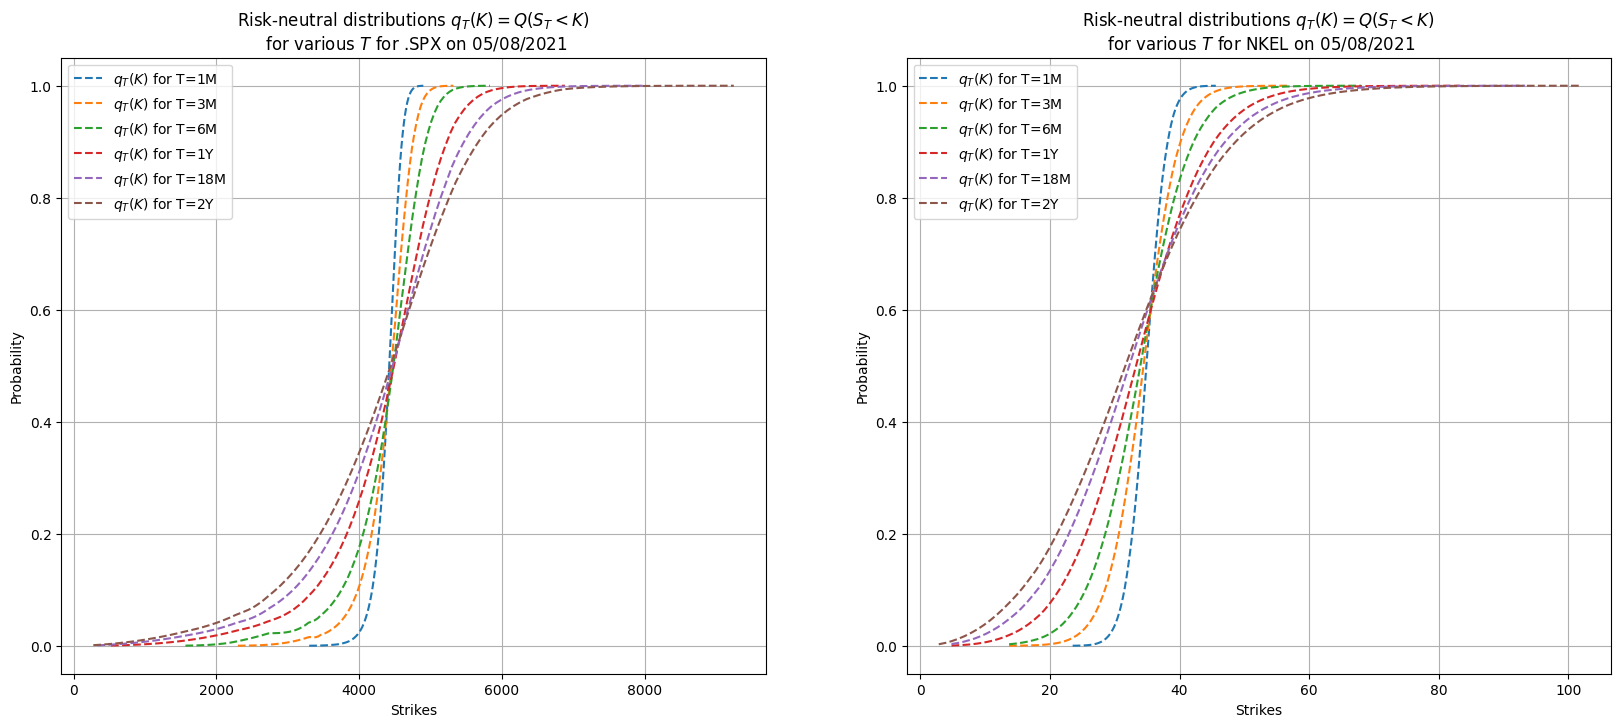

In [26]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
periods_to_plot = ["1M", "3M", "6M", "1Y", "18M", "2Y"]

for period_to_plot in periods_to_plot:
    strikes_and_distributinos_SPX = risk_neutral_distribution_SPX[period_to_plot]
    strikes_SPX, distributions_SPX  = strikes_and_distributinos_SPX["strikes"], strikes_and_distributinos_SPX["probabilities"]
    ax1.plot(strikes_SPX, distributions_SPX(strikes_SPX), label="$q_T(K)$ for T={}".format(period_to_plot), linestyle="dashed")
    ax1.set_xlabel("Strikes")
    ax1.set_ylabel("Probability")
    ax1.grid(True)
    ax1.legend()
    ax1.set_title("Risk-neutral distributions $q_T(K) = Q(S_T < K)$ \n for various $T$ for .SPX on {}".format(value_date))

    strikes_and_distributinos_NKEL = risk_neutral_distribution_NKEL[period_to_plot]
    strikes_NKEL, distributions_NKEL  = strikes_and_distributinos_NKEL["strikes"], strikes_and_distributinos_NKEL["probabilities"]
    ax2.plot(strikes_NKEL, distributions_NKEL(strikes_NKEL), label="$q_T(K)$ for T={}".format(period_to_plot), linestyle="dashed")
    ax2.set_xlabel("Strikes")
    ax2.set_ylabel("Probability")
    ax2.grid(True)
    ax2.legend()
    ax2.set_title("Risk-neutral distributions $q_T(K) = Q(S_T < K)$ \n for various $T$ for NKEL on {}".format(value_date))

plt.show()

Quantiles functions as a functions of probabilities $p$ for a given period $T$:

$$p \quad \longrightarrow \quad  q_T^{-1}(p) := \inf \{ x \in \mathbb{R}: p \leq q_T(x) \}$$

For each strike $K$ from a grid of observable strikes we get that 

$$q_T^{-1}(q_T(K)) = K,$$

therefore given the risk-neutral probabilities for each observable $K$, we get the quantile mapping for free. To get the quantiles for all other strikes we need an inter and extra-polations of a quantile values. The quantiles are a values of a magnitude of an underyling price. Therefore, for correct interpolation we use a linear (or cubic) one for log-quantiles. 

In [27]:
def create_exponential_lambda(foo: Callable):
   return lambda x: np.exp(foo(x))

def quantile_interpolator(probabilities: np.array, quantiles: np.array):
    """
    Inter-and-extrapolates the quantile function q^{-1}_T(\cdot) in log coordinates.

    Args:
        probabilities: array of probabilities (abscissas)
        quantiles: array of quantiles (ordinates)    
    """
    return interp1d(x=probabilities, y=np.log(quantiles), kind='linear', fill_value="extrapolate")

def quantile_mappings(risk_neutral_distribution: dict):
    """
    Inverts the distribution function q_T(\cdot) to retrieve the quantile q^{-1}_T(\cdot) function. 
    """
    quantile_mappings = defaultdict(dict)
    for period, strikes_and_probabilities in risk_neutral_distribution.items():
        quantile_mappings[period]["probabilities"] = strikes_and_probabilities["probabilities"](strikes_and_probabilities["strikes"])
        quantile_mappings[period]["quantiles"] = create_exponential_lambda(quantile_interpolator(probabilities=quantile_mappings[period]["probabilities"], 
                                                                                                 quantiles=strikes_and_probabilities["strikes"]))
        
    return quantile_mappings

In [28]:
quantile_mappings_SPX = quantile_mappings(risk_neutral_distribution=risk_neutral_distribution_SPX)
quantile_mappings_NKEL = quantile_mappings(risk_neutral_distribution=risk_neutral_distribution_NKEL)

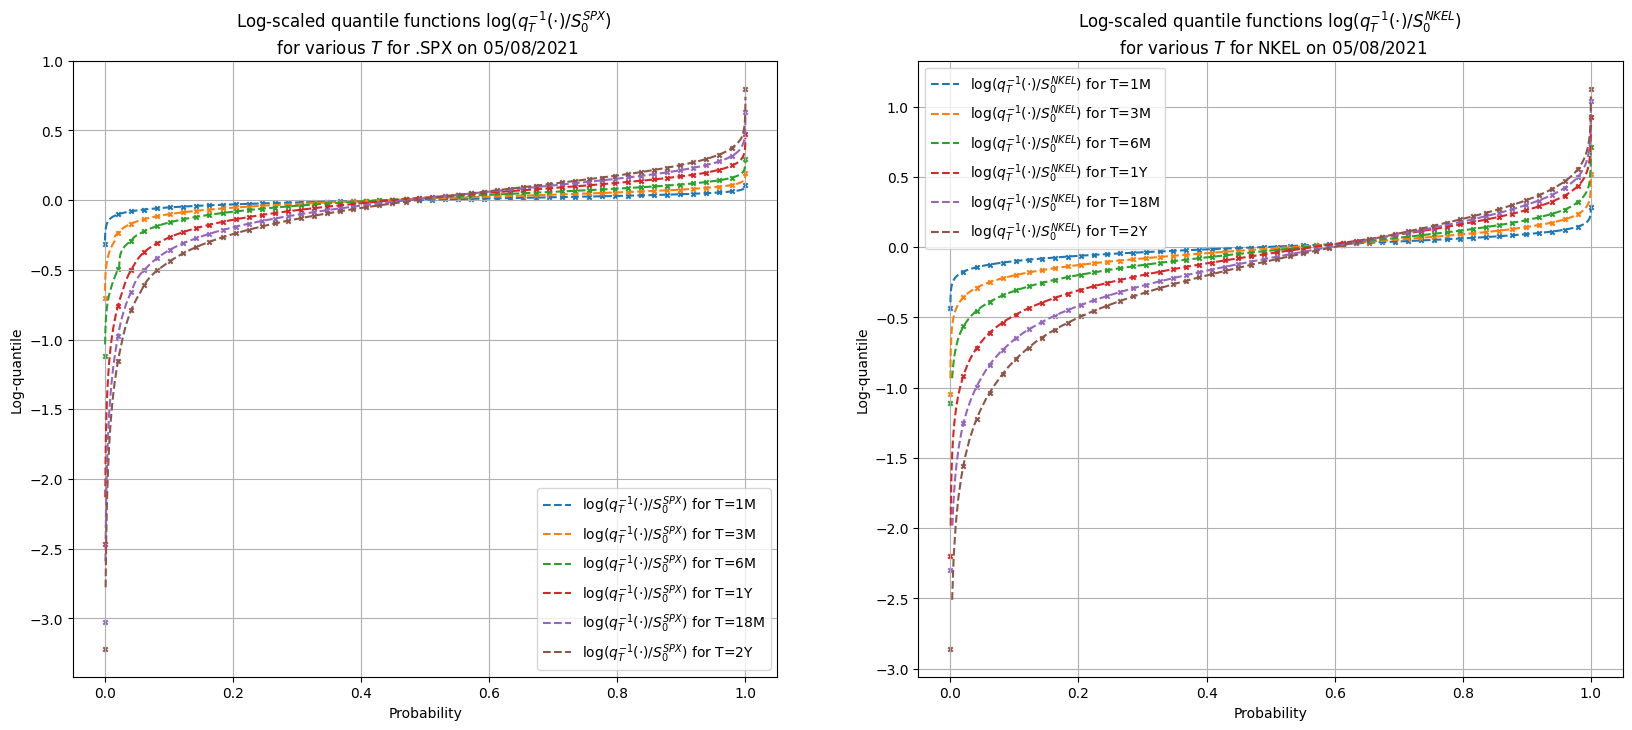

In [29]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
periods_to_plot = ["1M", "3M", "6M", "1Y", "18M", "2Y"]

for period_to_plot in periods_to_plot:
    probabilities_ = np.linspace(0, 1, 50)
    
    # .SPX quantile map
    probabilities_and_quantiles_SPX = quantile_mappings_SPX[period_to_plot]
    probabilities_SPX, quantiles_SPX  = probabilities_and_quantiles_SPX["probabilities"], probabilities_and_quantiles_SPX["quantiles"]

    ax1.scatter(probabilities_, np.log(quantiles_SPX(probabilities_) / S_spx), s=10, marker="x")
    ax1.plot(probabilities_SPX, np.log(quantiles_SPX(probabilities_SPX) / S_spx), 
             label="$\log(q_T^{-1}(\cdot) / S^{SPX}_0)$ for T=" + period_to_plot, linestyle="dashed")
    
    ax1.set_xlabel("Probability")
    ax1.set_ylabel("Log-quantile")
    ax1.grid(True)
    ax1.legend()
    ax1.set_title("Log-scaled quantile functions $\log(q^{-1}_T(\cdot) / S^{SPX}_0)$ \n for various $T$ for .SPX on " + value_date)

    # NKEL quantile map
    probabilities_and_quantiles_NKEL = quantile_mappings_NKEL[period_to_plot]
    probabilities_NKEL, quantiles_NKEL  = probabilities_and_quantiles_NKEL["probabilities"], probabilities_and_quantiles_NKEL["quantiles"]

    ax2.scatter(probabilities_, np.log(quantiles_NKEL(probabilities_) / S_nkel), s=10, marker="x")
    ax2.plot(probabilities_NKEL, np.log(quantiles_NKEL(probabilities_NKEL) / S_nkel), 
             label="$\log(q_T^{-1}(\cdot) / S^{NKEL}_0)$ for T=" + period_to_plot, linestyle="dashed")
    
    ax2.set_xlabel("Probability")
    ax2.set_ylabel("Log-quantile")
    ax2.grid(True)
    ax2.legend()
    ax2.set_title("Log-scaled quantile functions $\log(q^{-1}_T(\cdot) / S^{NKEL}_0)$ \n for various $T$ for NKEL on " + value_date)

plt.show()

Reprice the vanilla call options with numeric integration for sanity check

$$
\begin{align*}
PV^{call}_{0}(T, K) = DF(0, T) \cdot \int_{0}^{1} (q^{-1}_{T}(u) - K)_{+}  du.
\end{align*}
$$

In [30]:
def vanilla_pricing_check(quantile_mappings: dict, forwards_at_periods: np.array, 
                          periods_floats: np.array, period_to_strikes_and_volatility_curve_mapping: dict): 
    """
    Returns an implied volatilities obtained from a given given quantile mappings. 
    """
    period_to_strikes_and_volatility_curve_mapping_from_quantile_mapping = dict()
    for i, (period, strikes_and_quantiles) in enumerate(quantile_mappings.items()):
        strikes = period_to_strikes_and_volatility_curve_mapping[period]['strikes'] 
        period_to_strikes_and_volatility_curve_mapping_from_quantile_mapping[period] = dict()
        vols = []
        strikes_under_consideration = strikes[3:-4] # drop extreme strikes to vioalte numerical errors
        for K in strikes_under_consideration:
            price_from_integration = quad(lambda x: np.maximum(strikes_and_quantiles["quantiles"](x) - K, 0), 0, 1)[0]
            # U = np.random.uniform(0, 1, 10_000_000)
            # price_from_integration = dfs_at_periods[i] * np.mean(np.maximum(strikes_and_quantiles["quantiles"](U) - forwards_at_periods[i], 0))
            iv = implied_volatility_of_undiscounted_option_price(undiscounted_option_price=price_from_integration, 
                                                                 F=forwards_at_periods[i], K=K, 
                                                                 t=periods_floats[i], flag="c")
            vols.append(iv)
        period_to_strikes_and_volatility_curve_mapping_from_quantile_mapping[period]["strikes"] = strikes_under_consideration
        period_to_strikes_and_volatility_curve_mapping_from_quantile_mapping[period]["vols"] = np.array(vols)
    
    return period_to_strikes_and_volatility_curve_mapping_from_quantile_mapping
        

In [31]:
period_to_strikes_and_volatility_curve_mapping_from_quantile_mapping_SPX = \
    vanilla_pricing_check(quantile_mappings=quantile_mappings_SPX, 
                          forwards_at_periods=forwards_at_periods_SPX,
                          periods_floats=spx_periods_floats, 
                          period_to_strikes_and_volatility_curve_mapping=period_to_strikes_and_volatility_curve_mapping_SPX)

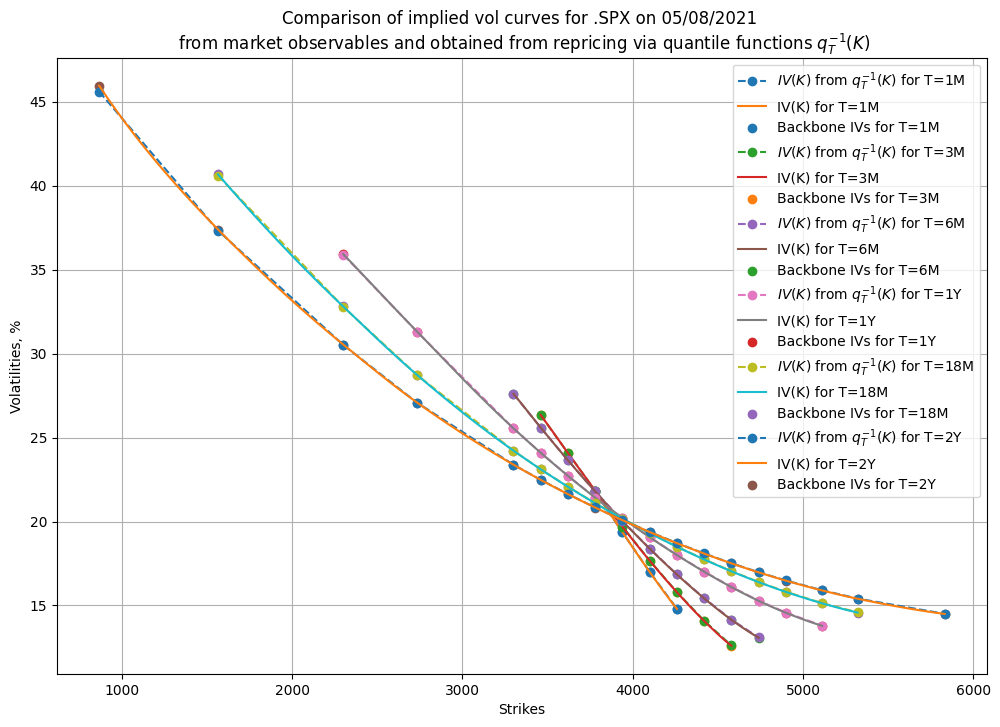

In [32]:
plt.figure(figsize=(12, 8))

for period_to_plot in periods_to_plot:
    strikes_and_volatility_curve_mapping = period_to_strikes_and_volatility_curve_mapping_from_quantile_mapping_SPX[period_to_plot]
    selected_strikes = strikes_and_volatility_curve_mapping["strikes"]
    selected_vols = strikes_and_volatility_curve_mapping["vols"]

    plt.plot(selected_strikes, selected_vols * 100, 
             label="$IV(K)$ from $q^{-1}_T(K)$ for T=" + period_to_plot, 
             linestyle = "--", marker="o")

    strikes_and_volatility_curve_mapping = period_to_strikes_and_volatility_curve_mapping_SPX[period_to_plot]
    vol_interpolator = strikes_and_volatility_curve_mapping["vols"]
    selected_vols = vol_interpolator(np.log(selected_strikes))

    strike_min, strike_max = np.min(selected_strikes), np.max(selected_strikes)
    high_frequency_strikes_grid = np.linspace(strike_min, strike_max, 100)

    plt.plot(high_frequency_strikes_grid, vol_interpolator(np.log(high_frequency_strikes_grid)) * 100, label="IV(K) for T={}".format(period_to_plot))
    plt.scatter(selected_strikes, selected_vols * 100, label="Backbone IVs for T={}".format(period_to_plot))

plt.title("Comparison of implied vol curves for .SPX on " + value_date + " \n from market observables and obtained from repricing via quantile functions $q^{-1}_T(K)$")
plt.xlabel("Strikes")
plt.ylabel("Volatilities, %")
plt.grid()
plt.legend()
plt.show()

In [33]:
period_to_strikes_and_volatility_curve_mapping_from_quantile_mapping_NKEL = \
    vanilla_pricing_check(quantile_mappings=quantile_mappings_NKEL, 
                          forwards_at_periods=forwards_at_periods_NKEL,
                          periods_floats=nkelyq_periods_floats, 
                          period_to_strikes_and_volatility_curve_mapping=period_to_strikes_and_volatility_curve_mapping_NKEL)

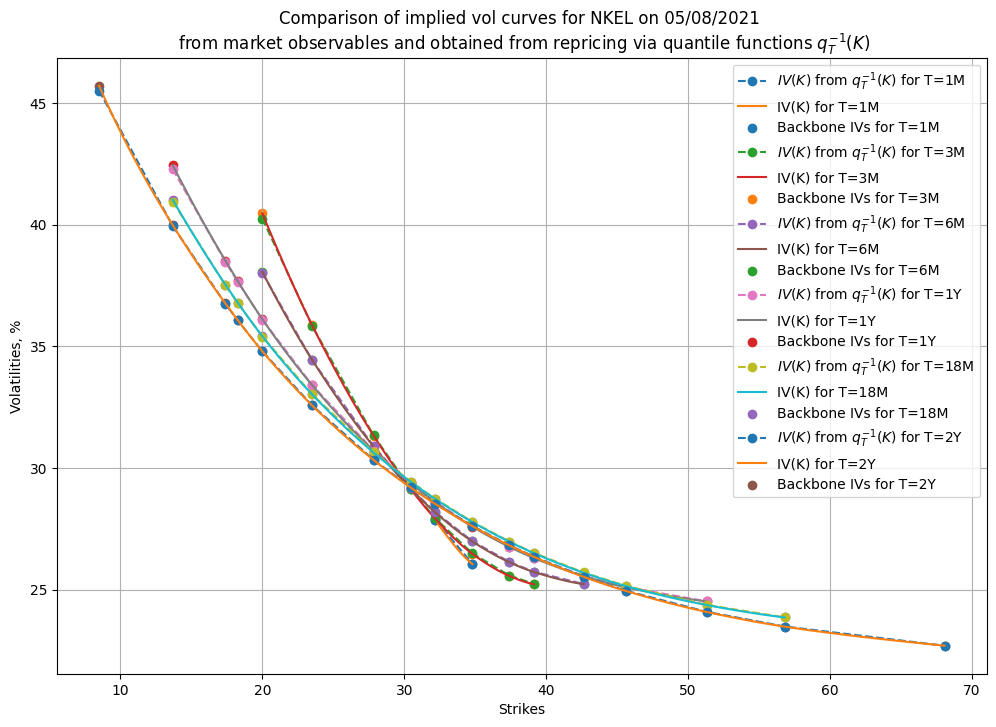

In [34]:
plt.figure(figsize=(12, 8))

for period_to_plot in periods_to_plot:
    strikes_and_volatility_curve_mapping = period_to_strikes_and_volatility_curve_mapping_from_quantile_mapping_NKEL[period_to_plot]
    selected_strikes = strikes_and_volatility_curve_mapping["strikes"]
    selected_vols = strikes_and_volatility_curve_mapping["vols"]

    plt.plot(selected_strikes, selected_vols * 100, 
             label="$IV(K)$ from $q^{-1}_T(K)$ for T=" + period_to_plot, 
             linestyle = "--", marker="o")

    strikes_and_volatility_curve_mapping = period_to_strikes_and_volatility_curve_mapping_NKEL[period_to_plot]
    vol_interpolator = strikes_and_volatility_curve_mapping["vols"]
    selected_vols = vol_interpolator(np.log(selected_strikes))

    strike_min, strike_max = np.min(selected_strikes), np.max(selected_strikes)
    high_frequency_strikes_grid = np.linspace(strike_min, strike_max, 100)

    plt.plot(high_frequency_strikes_grid, vol_interpolator(np.log(high_frequency_strikes_grid)) * 100, label="IV(K) for T={}".format(period_to_plot))
    plt.scatter(selected_strikes, selected_vols * 100, label="Backbone IVs for T={}".format(period_to_plot))

plt.title("Comparison of implied vol curves for NKEL on " + value_date + " \n from market observables and obtained from repricing via quantile functions $q^{-1}_T(K)$")
plt.xlabel("Strikes")
plt.ylabel("Volatilities, %")
plt.grid()
plt.legend()
plt.show()